[View in Colaboratory](https://colab.research.google.com/github/Zepx/collab-chainer-fashion-mnist/blob/master/CovNet_Deep_Learning_in_Chainer.ipynb)

**To edit or run this Jupyter Notebook, go to `File` and `Make a Copy` to your own Google Drive and open with Colaboratory.**

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer.png)


In [2]:
# Install Chainer and CuPy and NumPy
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 \
  /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80
!pip install chainer
import chainer as C
import numpy as np

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 2 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 1s (15.5 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

    100% |████████████████████████████████| 194.0MB 7.2kB/s 
    100% |████████████████████████████████| 81kB 9.2MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 399kB 2.0MB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/7c/f1/d8/b4898c5bc6175b5ca73d9ad1459b47bd97611482e7b766c482
  Running setup.py bdist_wheel for filelock ... - done
  Stored in directory: /content/.cache/pip/wheels/35/ba/67/4cc48738870c3b54f9e3b5d78bf9de130befb70c1d359faf8b
Successfully built chainer filelock
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
print(C.print_runtime_info())

Chainer: 4.0.0
NumPy: 1.14.2
CuPy:
  CuPy Version          : 4.0.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2104
None


![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-dataset.png)



Shape of train (50000, 2)
Shape of valid (10000, 2)
Shape of x (1, 28, 28)
Some raw x []


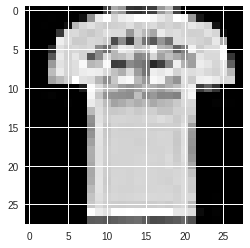

label: T-shirt/top


In [6]:
from chainer.datasets.fashion_mnist import get_fashion_mnist
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
          'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Download the MNIST data if you haven't downloaded it yet
train, test = get_fashion_mnist(withlabel=True, ndim=3)
train, valid = C.datasets.split_dataset_random(train, 50000, seed=0)

# set matplotlib so that we can see our drawing inside this notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Display an example from the MNIST dataset.
# `x` contains the input image array and `t` contains that target class
# label as an integer.
x, t = train[0]

print('Shape of train', np.shape(train))
print('Shape of valid', np.shape(valid))

print('Shape of x', x.shape)

print('Some raw x', x[200:220])

plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', labels[t])

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-iterator.png)

In [0]:
from chainer import iterators

# Choose the minibatch size.
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize,
                                     repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-model.png)

In [8]:
import chainer.functions as F
import chainer.links as L
from functools import partial

def MLP():
  layer = C.Sequential(L.Linear(100), F.relu)
  model = layer.repeat(2)
  model.append(L.Linear(10))
  
  return model

def CLP():
  layer = C.Sequential(
      L.Convolution2D(1, 32, 3, stride=1, pad=1), 
      F.relu,
      partial(F.max_pooling_2d, ksize=2),
      L.Convolution2D(32, 64, 3, stride=1, pad=1),
      F.relu,
      partial(F.max_pooling_2d, ksize=2),
      L.Convolution2D(64, 64, 3, stride=1, pad=1),
      F.relu
  )
  
  model = layer
  model.append(L.Linear(10))
  return model

#model = MLP()
model = CLP()

# Check the network structure
print(model.flatten())

model_loss = L.Classifier(model)

gpu_id = 0  # change to -1 if not using GPU

if gpu_id >= 0:
    model_loss.to_gpu(gpu_id)

0	Convolution2D	W(32, 1, 3, 3)	b(32,)	
1	relu
2	functools.partial(<function max_pooling_2d at 0x7f5382558268>, ksize=2)
3	Convolution2D	W(64, 32, 3, 3)	b(64,)	
4	relu
5	functools.partial(<function max_pooling_2d at 0x7f5382558268>, ksize=2)
6	Convolution2D	W(64, 64, 3, 3)	b(64,)	
7	relu
8	Linear	W(None)	b(10,)	



![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-optimizer.png)

In [0]:
# Choose an optimizer algorithm
optimizer = C.optimizers.Adam().setup(model_loss)

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-updater.png)

In [0]:
# Create the updater, using the optimizer
updater = C.training.StandardUpdater(train_iter, optimizer, device=gpu_id)

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-extensions.png)

In [0]:
from chainer.training import extensions as E

# Set up a trainer
trainer = C.training.Trainer(
    updater, (50, 'epoch'), out='result', extensions=[
        E.Evaluator(valid_iter, model_loss, device=gpu_id),
        E.dump_graph('main/loss'),
        E.LogReport(),
        E.PlotReport(['main/loss', 'validation/main/loss'],
                      'epoch', file_name='loss.png'),
        E.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                      'epoch', file_name='accuracy.png'),
        E.PrintReport(
              ['epoch', 'main/loss', 'validation/main/loss',
               'main/accuracy', 'validation/main/accuracy', 'elapsed_time'])])

**Note, to re-run the Trainer, the iterator definitions above must be re-run as well.**

In [12]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.48782     0.372523              0.825587       0.86343                   14.6116       
2           0.30427     0.304186              0.890485       0.888944                  19.8479       
3           0.258606    0.277227              0.90621        0.897152                  25.1219       
4           0.234775    0.266184              0.915281       0.906151                  30.3782       
5           0.210857    0.248222              0.924433       0.911096                  35.6034       
6           0.195074    0.236979              0.929147       0.910898                  40.8474       
7           0.178397    0.23852               0.935262       0.913667                  46.0629       
8           0.164716    0.238605              0.940124       0.914161                  51.2784       
9           0.150615    0.246764              0.945472       0.913667               

43          0.0133926   0.579924              0.995333       0.912678                  234.946       
44          0.0219206   0.563542              0.991908       0.914359                  240.18        
45          0.0061517   0.569269              0.997962       0.917326                  245.425       
46          0.00635666  0.625372              0.998017       0.912579                  250.651       
47          0.0210215   0.587943              0.992567       0.913568                  256.018       
48          0.0156522   0.634322              0.994391       0.914953                  261.228       
49          0.0100889   0.589233              0.996623       0.918018                  266.456       
50          0.0139994   0.643248              0.995284       0.910898                  271.689       


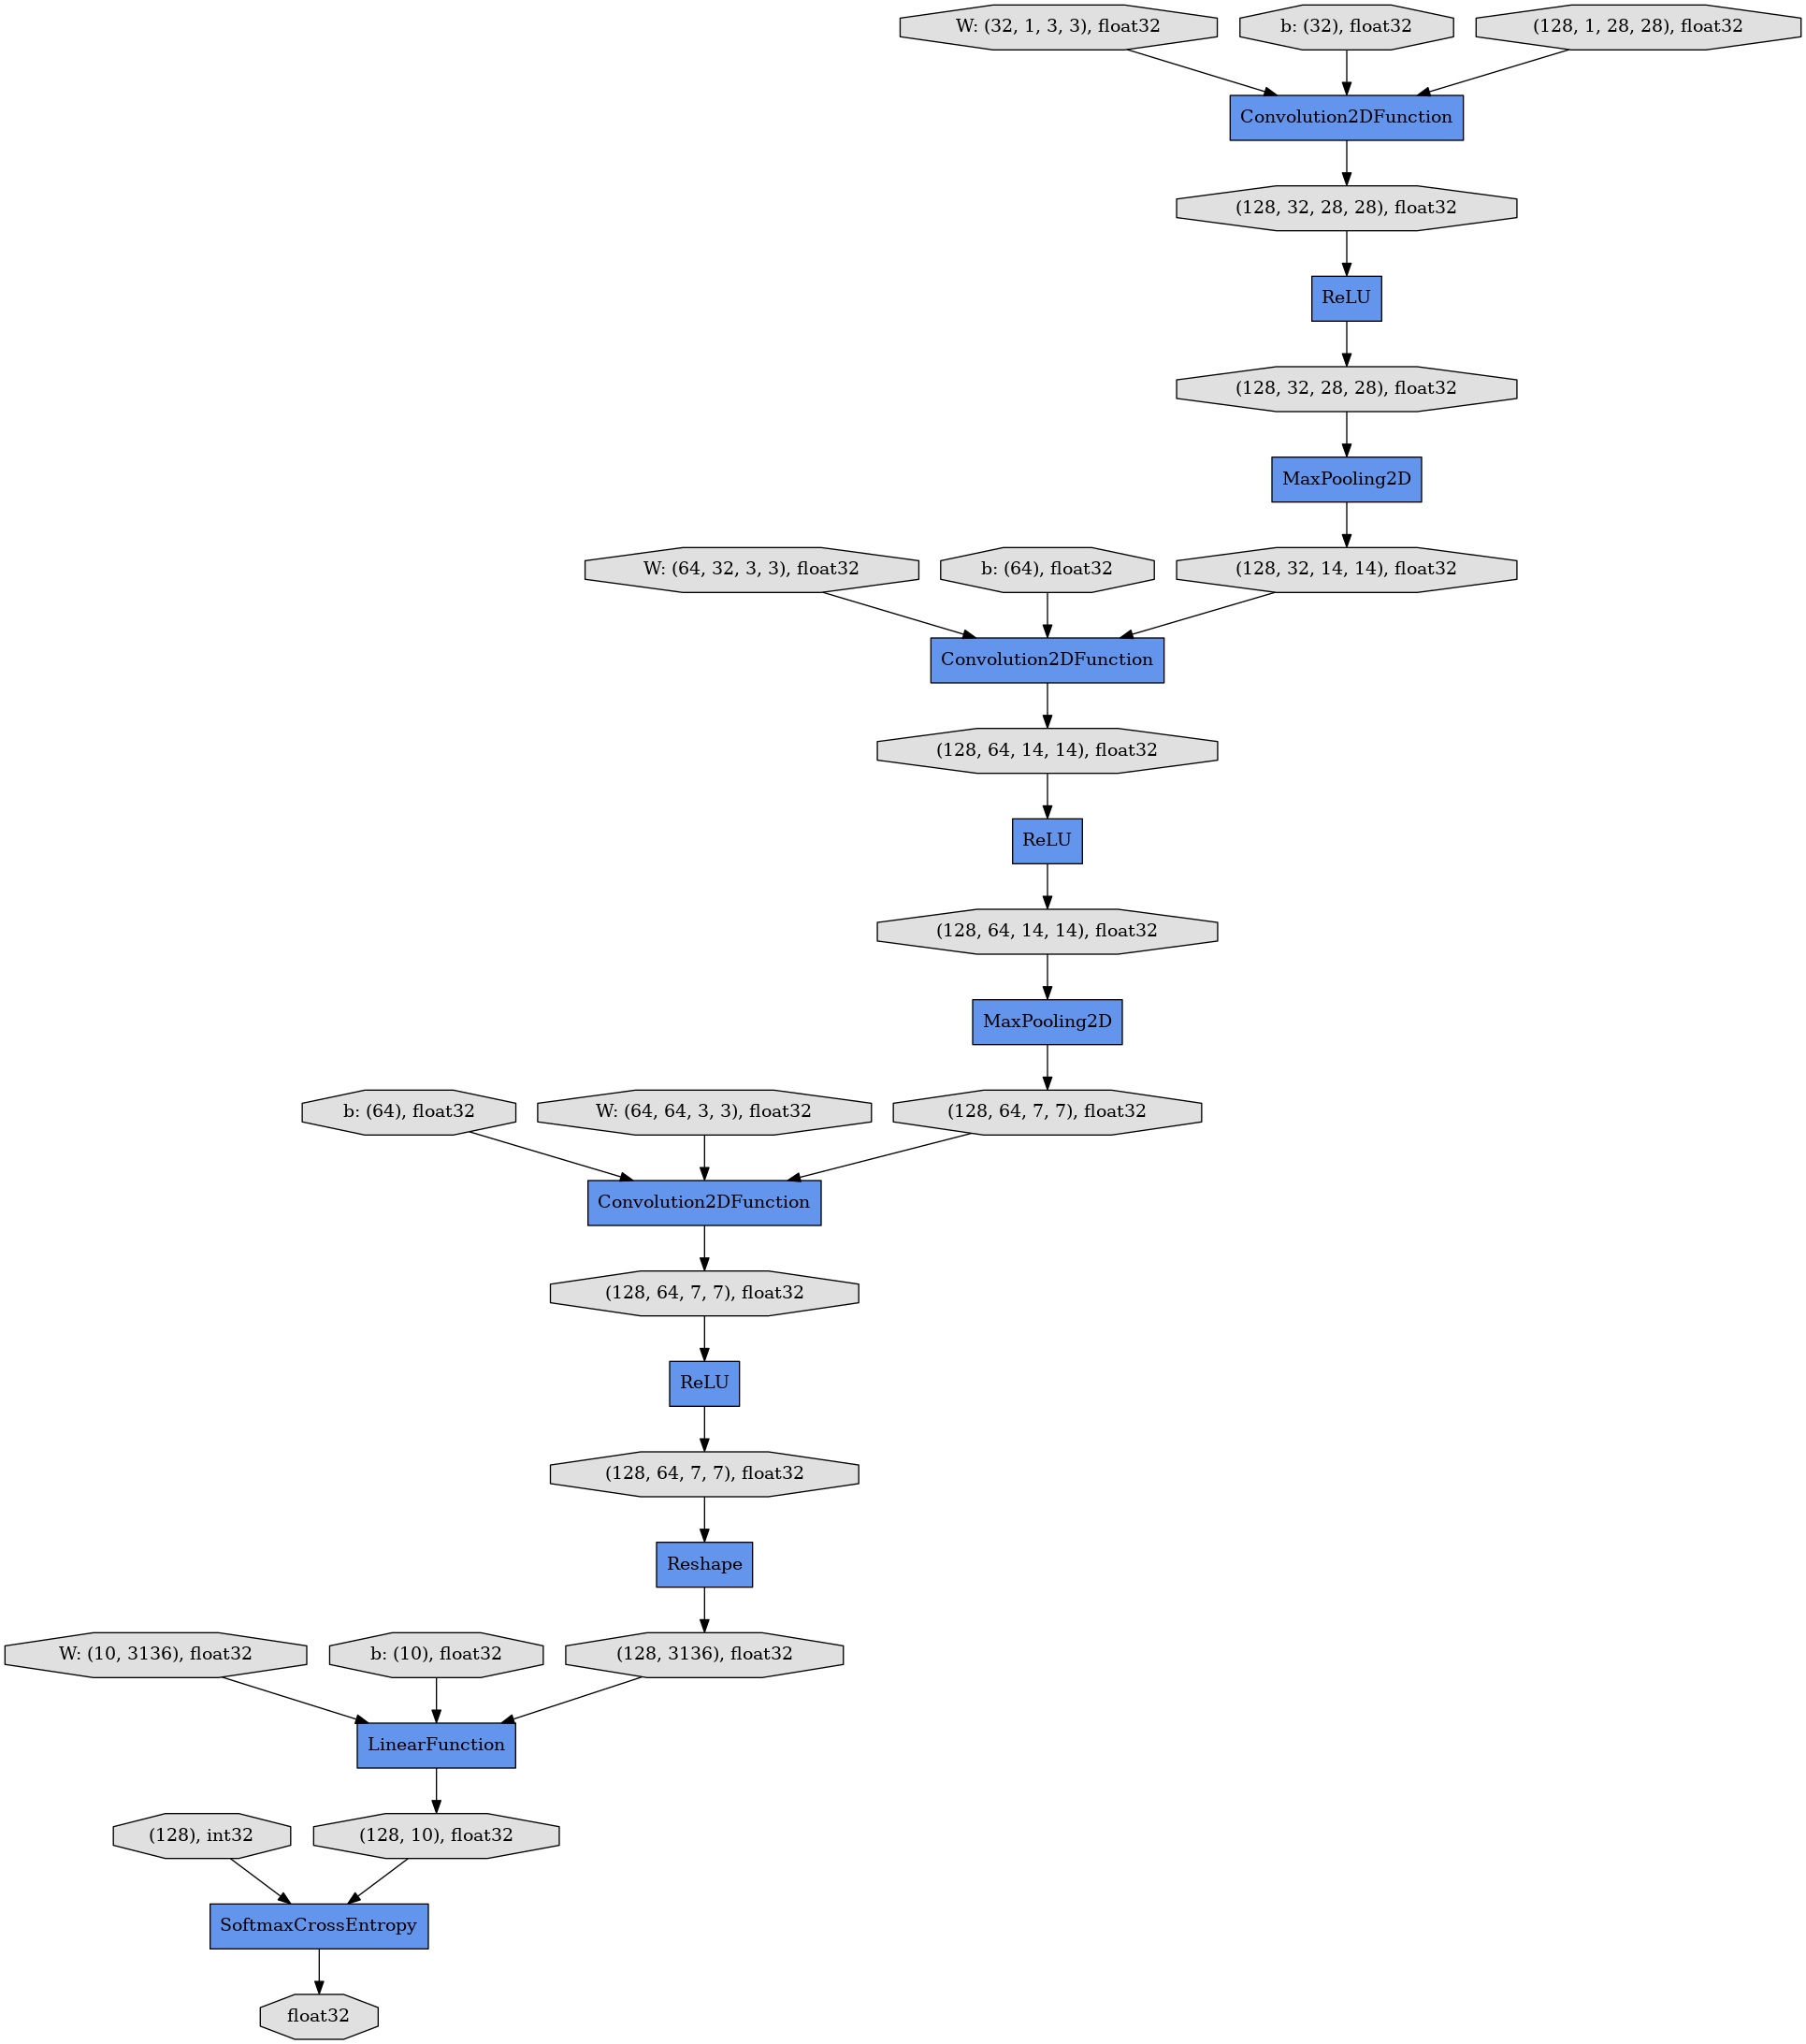

In [13]:
!apt-get -qq install -y graphviz > /dev/null
!dot -Tpng result/cg.dot -o result/cg.png

from IPython.display import Image
Image(filename='result/cg.png')

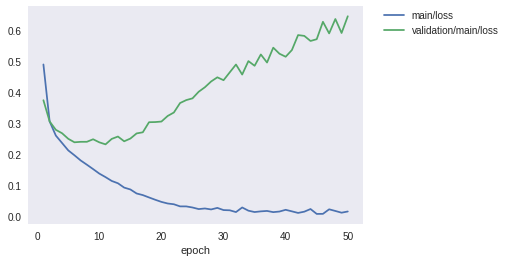

In [14]:
Image(filename='result/loss.png')


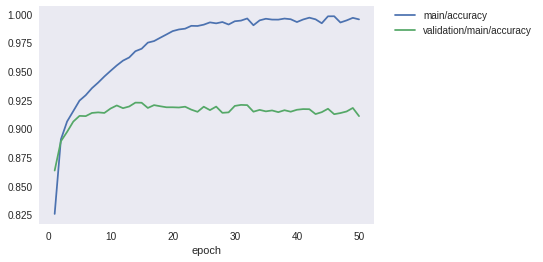

In [15]:
Image(filename='result/accuracy.png')

In [16]:
test_evaluator = E.Evaluator(test_iter, model_loss, device=gpu_id)
results = test_evaluator()

print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.91426027


In [17]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# check if the model is saved.
%ls -la my_mnist.model

-rw-r--r-- 1 root root 325066 Apr 24 14:27 my_mnist.model


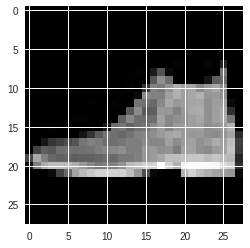

Ground truth: Ankle boot


In [19]:
# Create the inference (evaluation) model as the previous model
infer_model = CLP()

# Load the saved parameters into the inference model to overwrite 
serializers.load_npz('my_mnist.model', infer_model)

# Send the model to utilize GPU by to_GPU
if gpu_id >= 0:
    infer_model.to_gpu(gpu_id)
    
# Get a test image and label
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('Ground truth:', labels[t])

In [20]:
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

# change the shape to minibatch. 
# In this example, the size of minibatch is 1. 
# Inference using any mini-batch size can be performed.

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# to calculate by GPU, send the data to GPU, too. 
if gpu_id >= 0:
    x = to_gpu(x, 0)

# forward calculation of the model by sending X
with C.using_config('train', False):
  y = infer_model(x)

# The result is a Variable. Look at the contents by the attribute: .data. 
y = y.data

# send the gpu result to cpu
y = to_cpu(y)

print('Label values: ', np.around(y, decimals=1))

# The most probable number by looking at the argmax
pred_label = y.argmax(axis=1)

print('Predicted label:', labels[pred_label[0]])

(1, 28, 28) -> (1, 1, 28, 28)
Label values:  [[-16.9 -41.1 -43.7 -47.8 -49.2 -10.  -35.5  -8.9 -25.7  25.3]]
Predicted label: Ankle boot
